# Import thư viện và đọc dư liệu

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [210]:
def load_data(url):
  link = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
  data = pd.read_csv(link)
  return data

wecode_data_url = 'https://drive.google.com/file/d/1G3Mt-D-yrI3bcZnnnwGEpI6whwTiPWP1/view?usp=sharing'
score_training_url = 'https://drive.google.com/file/d/1FB2rBzu7PayeXW4Je_eK0f9o38W0CB3X/view?usp=sharing'
wecode_data = load_data(wecode_data_url)
score_training = load_data(score_training_url)

# xem và sử lý dữ liệu

In [211]:
wecode_data.head()

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07


In [212]:
wecode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


## label

In [213]:
#lay diem cuoi ki lam label
label = pd.DataFrame(score_training['id'])
label.rename(columns={'id':'user_id'}, inplace=True)
label['final_score'] = score_training['CK'].apply(pd.to_numeric, errors='coerce')
label.reindex()


,user_id,final_score
0,22,8.5
1,24,9.5
2,27,10.0
3,28,9.5
4,29,8.5
...,...,...
970,1857,4.0
971,1859,1.5
972,1862,7.5
973,1865,7.5


## feature

In [214]:
# so user
wecode_data['user_id'].nunique()

1159

In [215]:
# số lần submit
n_submit = wecode_data.groupby('user_id').size()

# so problem tham gia giai
solve_problem = wecode_data.groupby('user_id')['problem_id'].nunique()

# so problem da giai quyet xong
solved_problem = wecode_data[(wecode_data['is_final'] == 1) & (wecode_data['pre_score'] == 10000)].groupby('user_id')['problem_id'].nunique()
solved_problem = solved_problem.reindex(user_id, fill_value = 0)

# tong pre_score co is_final = 1 cua moi sv
sum_pres_core = wecode_data[wecode_data['is_final'] == 1].groupby('user_id')['pre_score'].sum()

data = pd.DataFrame({'n_submits': n_submit,
                     'solve_problems': solve_problem,
                     'solved_problems': solved_problem,
                     'sum_pre_score_is_final':sum_pre_score})
# tỉ lệ vấn đề đã giải quyết trên số vấn đề tham gia giải quyết
data['solved_problem/solve_problem'] = data['solved_problems']/data['solve_problems']
# tỉ lệ vấn đề tham gia giải quyết và số submittions
data['solve_problem/n_submit'] = data['solve_problems']/data['n_submits']
data.reset_index(inplace=True)

In [216]:
data.head()

,user_id,n_submits,solve_problems,solved_problems,sum_pre_score_is_final,solved_problem/solve_problem,solve_problem/n_submit
0,1,2,2,1,10000.0,0.500000,1.000000
1,4,54,41,37,370000.0,0.902439,0.759259
2,5,6,5,3,30000.0,0.600000,0.833333
3,6,130,88,84,850000.0,0.954545,0.676923
4,7,5,2,0,9209.0,0.000000,0.400000


In [217]:
# kết hợp features và label
data = pd.merge(data, label, on='user_id', how='inner')
data

,user_id,n_submits,solve_problems,solved_problems,sum_pre_score_is_final,solved_problem/solve_problem,solve_problem/n_submit,final_score
0,24,164,78,72,750299.0,0.923077,0.475610,9.5
1,27,13,5,3,39000.0,0.600000,0.384615,10.0
2,29,199,80,72,762760.0,0.900000,0.402010,8.5
3,34,218,84,81,822888.0,0.964286,0.385321,6.5
4,35,297,147,140,1477000.0,0.952381,0.494949,4.5
...,...,...,...,...,...,...,...,...
848,1856,64,31,23,270790.0,0.741935,0.484375,7.5
849,1857,55,34,33,386000.0,0.970588,0.618182,4.0
850,1859,31,27,3,39000.0,0.111111,0.870968,1.5
851,1862,12,6,4,40000.0,0.666667,0.500000,7.5


In [218]:
#Bỏ row có chứa Nan
data.dropna(axis=0, inplace=True)
data

,user_id,n_submits,solve_problems,solved_problems,sum_pre_score_is_final,solved_problem/solve_problem,solve_problem/n_submit,final_score
0,24,164,78,72,750299.0,0.923077,0.475610,9.5
1,27,13,5,3,39000.0,0.600000,0.384615,10.0
2,29,199,80,72,762760.0,0.900000,0.402010,8.5
3,34,218,84,81,822888.0,0.964286,0.385321,6.5
4,35,297,147,140,1477000.0,0.952381,0.494949,4.5
...,...,...,...,...,...,...,...,...
848,1856,64,31,23,270790.0,0.741935,0.484375,7.5
849,1857,55,34,33,386000.0,0.970588,0.618182,4.0
850,1859,31,27,3,39000.0,0.111111,0.870968,1.5
851,1862,12,6,4,40000.0,0.666667,0.500000,7.5


# visualize

Text(0, 0.5, 'score')

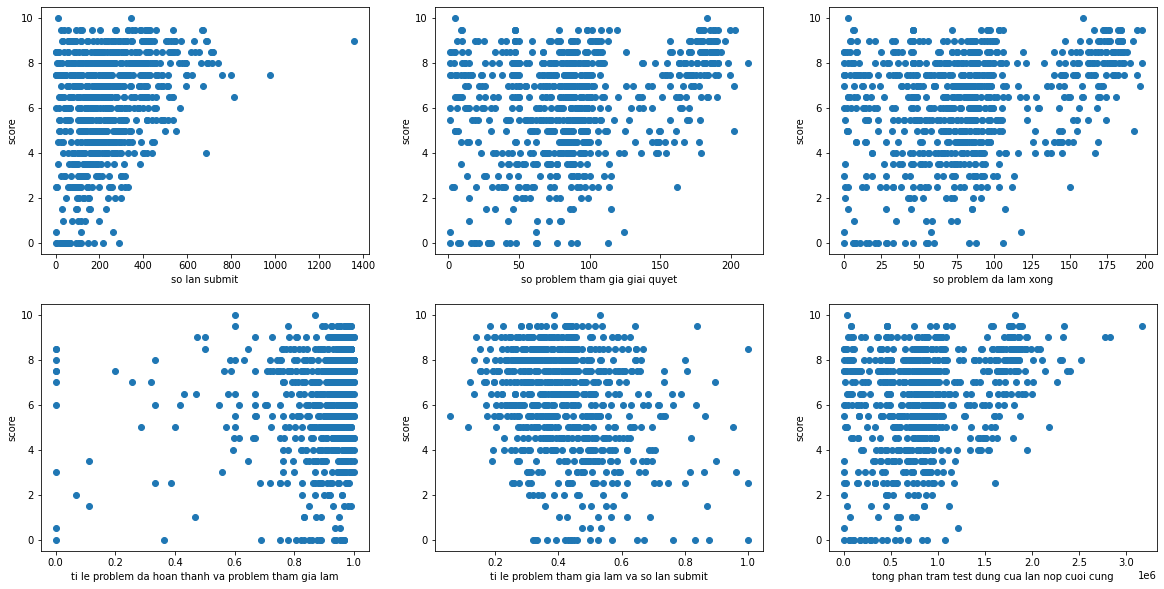

In [219]:
columns = data.columns
plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.scatter(data['n_submits'], data['final_score'])
plt.xlabel('so lan submit')
plt.ylabel('score')

plt.subplot(232)
plt.scatter(data['solve_problems'], data['final_score'])
plt.xlabel('so problem tham gia giai quyet')
plt.ylabel('score')

plt.subplot(233)
plt.scatter(data['solved_problems'], data['final_score'])
plt.xlabel('so problem da lam xong')
plt.ylabel('score')

plt.subplot(234)
plt.scatter(data['solved_problem/solve_problem'], data['final_score'])
plt.xlabel('ti le problem da hoan thanh va problem tham gia lam')
plt.ylabel('score')

plt.subplot(235)
plt.scatter(data['solve_problem/n_submit'], data['final_score'])
plt.xlabel('ti le problem tham gia lam va so lan submit')
plt.ylabel('score')

plt.subplot(236)
plt.scatter(data['sum_pre_score_is_final'], data['final_score'])
plt.xlabel('tong phan tram test dung cua lan nop cuoi cung')
plt.ylabel('score')


# Model

In [220]:
data

,user_id,n_submits,solve_problems,solved_problems,sum_pre_score_is_final,solved_problem/solve_problem,solve_problem/n_submit,final_score
0,24,164,78,72,750299.0,0.923077,0.475610,9.5
1,27,13,5,3,39000.0,0.600000,0.384615,10.0
2,29,199,80,72,762760.0,0.900000,0.402010,8.5
3,34,218,84,81,822888.0,0.964286,0.385321,6.5
4,35,297,147,140,1477000.0,0.952381,0.494949,4.5
...,...,...,...,...,...,...,...,...
848,1856,64,31,23,270790.0,0.741935,0.484375,7.5
849,1857,55,34,33,386000.0,0.970588,0.618182,4.0
850,1859,31,27,3,39000.0,0.111111,0.870968,1.5
851,1862,12,6,4,40000.0,0.666667,0.500000,7.5


In [221]:
# phan chia du lieu
data.drop(['user_id'],axis=1, inplace=True)
y = data['final_score']
X = data.drop('final_score', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [222]:
#tạo model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [223]:
# predict va tinh MSE
y_pre = model.predict(X_test)
MSE = mean_squared_error(y_pre, y_test)
print(f'MSE: {MSE}')

MSE: 4.596023903805625
